In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error , mean_absolute_percentage_error

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 3.7/376.0 MB 18.2 MB/s eta 0:00:21
    --------------------------------------- 7.9/376.0 MB 18.7 MB/s eta 0:00:20
   - -------------------------------------- 11.5/376.0 MB 19.0 MB/s eta 0:00:20
   - -------------------------------------- 15.7/376.0 MB 19.0 MB/s eta 0:00:19
   -- ------------------------------------- 19.1/376.0 MB 18.3 MB/s eta 0:00:20
   -- ------------------------------------- 23.3/376.0 MB 18.5 MB/s eta 0:00:20
   -- ------------------------------------- 27.3/376.0 MB 18.6 MB/s eta 0:00:19
   --- ------------------------------------ 31.2/376.0 MB 18.7 MB/s eta 0:00:19
   --- ------------------------------------ 35.1/376.0 MB 18.6 MB/s eta 0:00:19
   ---- ----------------------------------- 39.1/376.0 MB 18.7 MB/s eta 0:00:19
   ---- ----------------------------------- 43.3/376.0 MB 18.7 MB/s eta 0:00:18
   ----- ---------------------------------- 47.2/37

In [18]:
stocks = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv", index_col=0, header=[0,1])
stocks.tail()

Adj Close                                                  \
                  AAPL         GLD        MSFT         QQQ         SPY   
Date                                                                     
2023-12-22  193.600006  190.270004  374.579987  408.165314  473.649994   
2023-12-26  193.050003  191.720001  374.660004  410.664001  475.649994   
2023-12-27  193.149994  192.589996  374.070007  411.500000  476.510010   
2023-12-28  193.580002  191.470001  375.279999  411.299988  476.690002   
2023-12-29  192.529999  191.169998  376.040009  409.519989  475.309998   

                                        Close                          ...  \
                  TSLA        USO        AAPL         GLD        MSFT  ...   
Date                                                                   ...   
2023-12-22  252.539993  68.690002  193.600006  190.270004  374.579987  ...   
2023-12-26  256.609985  70.209999  193.050003  191.720001  374.660004  ...   
2023-12-27  261.440002  68.919998  193.149994  192.589996  374.070007  ...   
2023-12-28  253.179993  67.180000  193.580002  191.470001  375.279999  ...   
2023-12-29  248.479996  66.650002  192.529999  191.169998  376.040009  ...   

                  Open                           Volume                     \
                   SPY        TSLA        USO      AAPL      GLD      MSFT   
Date                                                                         
2023-12-22  473.859985  256.760010  69.629997  37122800  7175400  17091100   
2023-12-26  474.070007  254.490005  70.519997  28919300  4502700  12673100   
2023-12-27  475.440002  258.350006  70.019997  48087700  5813300  14905400   
2023-12-28  476.880005  263.660004  68.349998  34049900  6171500  14327000   
2023-12-29  476.489990  255.100006  67.680000  42628800  4610300  18723000   

                                                     
                 QQQ        SPY       TSLA      USO  
Date                                                 
2023-12-22  34292400   67126600   93249800  4299800  
2023-12-26  22722500   55387000   86892400  4996900  
2023-12-27  31980500   68000300  106494400  3785600  
2023-12-28  27029200   77158100  113619900  5754500  
2023-12-29  42633400  122234100  100615300  3301800  

[5 rows x 42 columns]

In [32]:
df = stocks['Close'][['AAPL']]
df.head()

,AAPL
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502


In [26]:
idx = pd.period_range(min(df.index), max(df.index))
df = df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')
df.tail(10)

,AAPL
2023-12-18,195.889999
2023-12-19,196.940002
2023-12-20,194.830002
2023-12-21,194.679993
2023-12-22,193.600006
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994
2023-12-28,193.580002
2023-12-29,192.529999


In [38]:
df['LogAAPL']= np.log(df['AAPL'])
df

,AAPL,LogAAPL
Date,,
2018-01-02,43.064999,3.762711
2018-01-03,43.057499,3.762536
2018-01-04,43.257500,3.767171
2018-01-05,43.750000,3.778492
2018-01-08,43.587502,3.774770
...,...,...
2023-12-22,193.600006,5.265794
2023-12-26,193.050003,5.262949
2023-12-27,193.149994,5.263467


In [48]:
df2 = df

In [52]:
df = df[509:]
df.shape

(1000, 2)

In [54]:
test_period = 100
train_period = len(df) - test_period

print("train_period:", train_period)
print("test_period:", test_period)

train_period: 900
test_period: 100


In [56]:
train = df.iloc[:train_period]
test  = df.iloc[train_period:]

In [60]:
series = df['LogAAPL'].dropna().to_numpy()

Tx = 100 # using the past 100 observations to forecast the next one.
Ty = 1 # forecasting only one step ahead
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Tx, 1)
Y = np.array([series[t+Tx+Ty-1] for t in range(len(series) - Tx-Ty+1)]).reshape(-1, Ty)
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (900, 100, 1) Y: (900, 1) N: 900


In [62]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

In [100]:
n_features = 1 
inputs = keras.Input(shape=(Tx, n_features))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM_singleOutput.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(Xtrain, Ytrain,
                    epochs=100,
                    validation_data=(Xtest,Ytest),
                    callbacks=callbacks)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 17.0419 - mae: 4.0393 - val_loss: 4.3665 - val_mae: 2.0890
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0099 - mae: 1.3465 - val_loss: 0.2854 - val_mae: 0.5321
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0638 - mae: 0.2102 - val_loss: 0.0730 - val_mae: 0.2659
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0308 - mae: 0.1400 - val_loss: 0.0599 - val_mae: 0.2401
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0286 - mae: 0.1304 - val_loss: 0.0546 - val_mae: 0.2294
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0225 - mae: 0.1169 - val_loss: 0.0608 - val_mae: 0.2434
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0215 - mae: 0.1192 - val_loss: 0.0160 - val_mae: 0.1210
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0177 - mae: 0.1061 - val_loss: 0.0444 - val_mae: 0.2080
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - l

In [102]:
model = tf.keras.models.load_model('LSTM_singleOutput.keras')

In [120]:
train_predictions = model.predict(Xtrain)
test_predictions = model.predict(Xtest)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [122]:
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

train_indicator[:Tx] = False

df.loc[train_indicator, '1step_train'] =  train_predictions
df.loc[test_indicator, '1step_test'] =  test_predictions

In [128]:
df.iloc[899:]

,AAPL,LogAAPL,1step_train,1step_test,1step_train_orig,1step_test_orig
Date,,,,,,
2023-08-08,179.800003,5.191845,5.235205,NaN,187.767532,NaN
2023-08-09,178.190002,5.182850,NaN,5.225413,NaN,185.937927
2023-08-10,177.970001,5.181615,NaN,5.216285,NaN,184.248474
2023-08-11,177.789993,5.180603,NaN,5.208739,NaN,182.863281
2023-08-14,179.460007,5.189952,NaN,5.202780,NaN,181.776840
...,...,...,...,...,...,...
2023-12-22,193.600006,5.265794,NaN,5.264635,NaN,193.375626
2023-12-26,193.050003,5.262949,NaN,5.262683,NaN,192.998703
2023-12-27,193.149994,5.263467,NaN,5.260474,NaN,192.572693


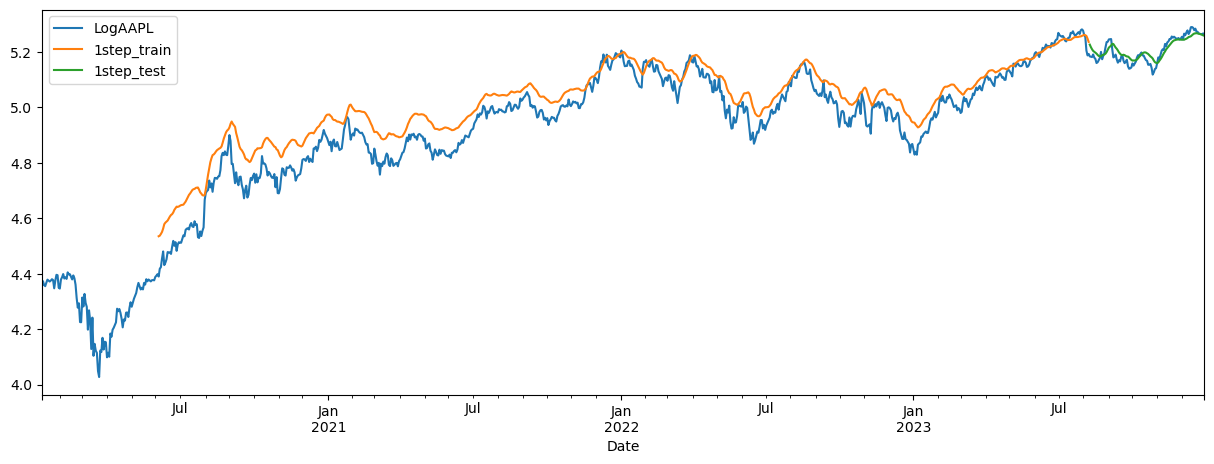

In [126]:
df[['LogAAPL', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [134]:
df['1step_train_orig'] = np.exp(df['1step_train'])
df['1step_test_orig'] = np.exp(df['1step_test'])

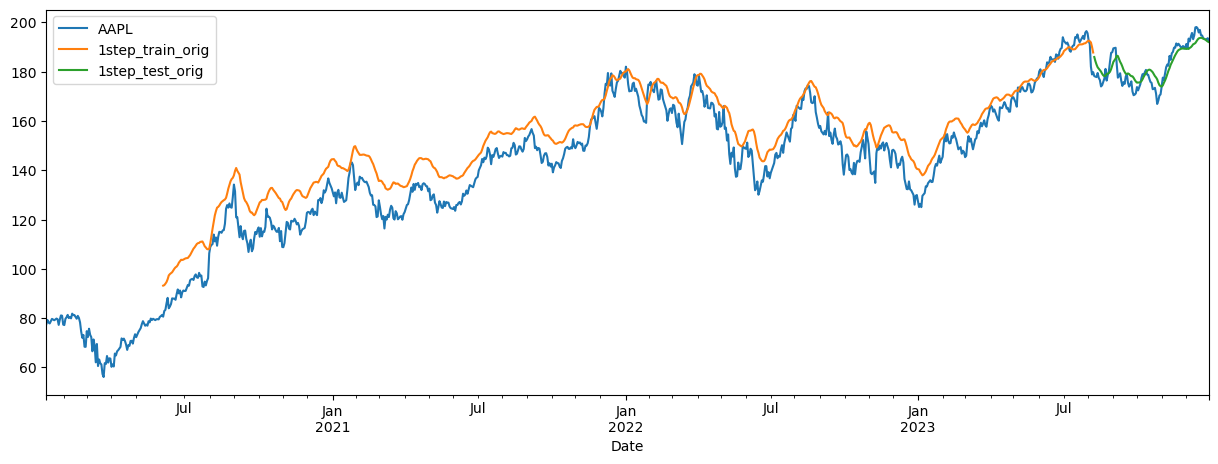

In [136]:
df[['AAPL', '1step_train_orig', '1step_test_orig']].plot(figsize=(15, 5));

In [144]:
Xtest.shape

Xtest[0].shape

Xtest[0].reshape(1, -1, 1).shape

(1, 100, 1)

In [146]:
multistep_predictions = []

# first test input
last_x = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The last_x array, which serves as input for the next prediction, is updated. The np.roll(last_x, -1) shifts all elements of last_x one position to the left. 
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  last_x = np.roll(last_x, -1)
  last_x[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [148]:
df.loc[test_indicator, 'multistep_test'] = multistep_predictions

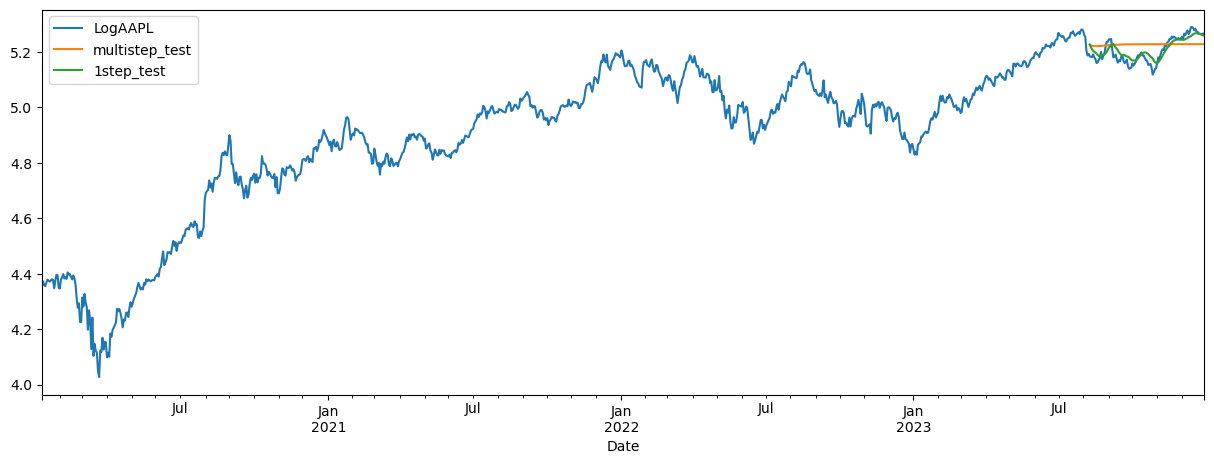

In [150]:
df[['LogAAPL', 'multistep_test', '1step_test']].plot(figsize=(15, 5));